In [152]:
# import modules
import cv2
import numpy as np
from glob import glob
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from math import sqrt

# escolha o conjunto de imagens
path = '../../../images/virtual/'
image_set = glob(path + '7x7/original/test/*.jpg')

In [153]:
# Funções de calibração

#Reconstrução do tabuleiro
def construct3DPoints(patternSize,squareSize):
    X = np.zeros((patternSize[0]*patternSize[1],3), np.float32)
    X[:,:2] = np.mgrid[0:patternSize[0],0:patternSize[1]].T.reshape(-1,2)
    X = X * squareSize # Square size não interfere na calibração -> somente um fator de escala
                       # o square size não é utilizado na calibração dos cara de stanford
    return X

#Detectando os corners
def detectCorners(images, boardPoints, patternSize):
    worldPoints = []
    imagePoints = [] 

    img_size = 0
    counter = 0
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img_size = gray.shape[::-1]
        ret, corners = cv2.findChessboardCornersSB(gray, patternSize, None)
        if ret == True:
            #print("Corners found in image " + str(fname)) #- see if corners are found 
            #corners2 = cv2.cornerSubPix(gray, corners, (11,11), (-1,-1), criteria=(cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001))
            worldPoints.append(boardPoints)
            imagePoints.append(corners)
            counter+=1

    print("Corners found in " + str(counter) + " images")
    #print(img_size)
    return worldPoints, imagePoints, img_size

#Descobrindo os intrisicos, extrinsecos e o erro de reprojeção 
def calibrate(images, useFisheye, patternSize, squareSize):

    boardPoints = construct3DPoints(patternSize, squareSize)

    worldPoints, imagePoints, imgSize = detectCorners(images, boardPoints, patternSize)

    if useFisheye:
        flagsCalib = cv2.fisheye.CALIB_RECOMPUTE_EXTRINSIC+cv2.fisheye.CALIB_FIX_SKEW+cv2.fisheye.CALIB_CHECK_COND
        calibrateCriteria = (cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER,30, 1e-12)

        ret, cameraMatrix, k, R, t = cv2.fisheye.calibrate(np.expand_dims(np.asarray(worldPoints), -2), imagePoints, imgSize, None, None,
                                                                    flags=flagsCalib,criteria=calibrateCriteria)
    else:
        flagsCalib = cv2.CALIB_RATIONAL_MODEL

        ret, cameraMatrix, k, rvecs, tvecs, stdIntrinc, stdExtrinsic, perViewError = cv2.calibrateCameraExtended(worldPoints, imagePoints, imgSize, None, None,
                                                                flags=flagsCalib)

    print("RMS re-projection error:", ret)
    print("The median re-projection error", np.median(perViewError))
    print("Camera Matrix:\n", cameraMatrix)
    print("Distortion Parameters:\n", k)

    return cameraMatrix, k, rvecs, tvecs, stdIntrinc, stdExtrinsic, perViewError

def calculate_mean_error(image_set, pattern_size, square_size, camera_matrix, distortion):
    
    # Create empty arrays for rotation and translation vectors
    rvecs = []
    tvecs = []
    errors = []
    
    # Define the world board points
    board_points = construct3DPoints(pattern_size, square_size)
    board_points = board_points.astype('float32')
    
    # Calculate image points in each image
    for image in image_set:
        img = cv2.imread(image)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # Detect chessboard corners in the image
        ret, detected_image_points = cv2.findChessboardCornersSB(gray, pattern_size, None)
        
        # If it was detected
        if ret == True: 

            # Calculate extrinsic parameters 
            _, rvec, tvec = cv2.solvePnP(board_points, detected_image_points, camera_matrix, distortion)
            rvecs.append(rvec)
            tvecs.append(tvecs)

            # Calculate projected image points
            projected_image_points, _ = cv2.projectPoints(board_points, rvec, tvec, camera_matrix, distortion)

            # Find the Euclidean Distance between projected and detected image points
            error = cv2.norm(detected_image_points, projected_image_points, normType= cv2.NORM_L2) / len(projected_image_points)
            
            errors.append(error)
            
            print(f"Mean Error of Image {image}:", error, "px")
    
    mean_error = np.median(errors)
    
    print("Median error: ", mean_error)
    
    return mean_error

def calculate_rms_error(image_set, pattern_size, square_size, camera_matrix, distortion):
    
    # Create empty arrays for rotation and translation vectors
    rvecs = []
    tvecs = []
    errors = []

    # Define the world board points
    board_points = construct3DPoints(pattern_size, square_size)

    # Calculate the detected image points
    for image in image_set:
        img = cv2.imread(image)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # Detect chessboard corners in the image
        ret, corners = cv2.findChessboardCornersSB(gray, pattern_size, None)

        # If it was detected
        if ret == True:
            
            # Calculate extrinsic parameters
            _, rvec, tvec = cv2.solvePnP(board_points, corners, camera_matrix, distortion)
            rvecs.append(rvec)
            tvecs.append(tvecs)

            # Calculate projected image points
            image_points, _ = cv2.projectPoints(board_points, rvec, tvec, camera_matrix, distortion)

            # Find the Euclidean Distance between projected and detected image points
            error = cv2.norm(corners, image_points, normType= cv2.NORM_L2) / sqrt(len(image_points))
            errors.append(error)

            print(f"RMS Error of Image {image}:", error, "px")

    rms_error = np.median(errors)

    print("Median RMS error: ", rms_error)

    return rms_error

Calibração Inicial - Detectar Outliers

In [154]:
# Calibração Inicial 
camera_matrix, distortion, rotation, translation, stdInt, stdExt, perViewError = calibrate(image_set, useFisheye = False, patternSize = (7,7), squareSize = 30)

Corners found in 20 images
RMS re-projection error: 0.250877723818188
The median re-projection error 0.24312653425188566
Camera Matrix:
 [[415.73641877   0.         238.56649595]
 [  0.         415.72140854 239.58304486]
 [  0.           0.           1.        ]]
Distortion Parameters:
 [[-1.54783162e+01  7.67039242e+01  5.48681211e-04 -5.55128922e-04
  -8.15486101e+01 -1.54780231e+01  7.67056519e+01 -8.15680402e+01
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]


In [155]:
perViewError.reshape(20,)

error = [0.27555139, 0.19183595, 0.2339844 , 0.2442912 , 0.21021585,
       0.21979921, 0.21366973, 0.22803501, 0.27671882, 0.20763292,
       0.25810807, 0.25622183, 0.24196187, 0.22971068, 0.33850582,
       0.30264016, 0.27840132, 0.25627337, 0.27089499, 0.23551575]

rms_error = 0.250877723818188


In [156]:
import os

new_image_set = []
for image in image_set:
    nome_arquivo = os.path.basename(image)
    new_image_set.append(nome_arquivo)

new_image_set

['image0.jpg',
 'image1.jpg',
 'image10.jpg',
 'image11.jpg',
 'image12.jpg',
 'image13.jpg',
 'image14.jpg',
 'image15.jpg',
 'image16.jpg',
 'image17.jpg',
 'image18.jpg',
 'image19.jpg',
 'image2.jpg',
 'image3.jpg',
 'image4.jpg',
 'image5.jpg',
 'image6.jpg',
 'image7.jpg',
 'image8.jpg',
 'image9.jpg']

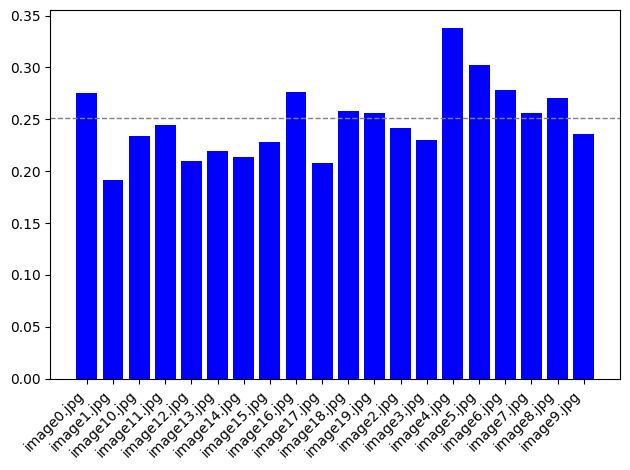

In [157]:
plt.figure()
plt.bar(new_image_set, error, color = 'blue')

plt.axhline(y=rms_error, color='gray', linestyle='--', linewidth=1, label=f'Média: {rms_error:.2f}')

plt.xticks(rotation=45, ha='right')  # Rotacionar os rótulos das imagens para melhor visualização
plt.tight_layout()  # Ajusta o layout para se encaixar bem na figura
plt.show()

In [158]:
new_image_set.remove('image4.jpg')
new_image_set.remove('image5.jpg')
new_image_set.remove('image6.jpg')

complet_new_image_set = []
for image in new_image_set:
    path = '../../../images/virtual/7x7/original/test/'
    path_image = path + image
    complet_new_image_set.append(path_image)

Calibração final - Divisão em Treino e teste

In [159]:
zeros = np.zeros(len(complet_new_image_set))

images_train, images_test, y_train, y_test = train_test_split(complet_new_image_set, zeros, test_size=0.3) 

In [160]:
camera_matrix, distortion, rotation, translation, stdInt, stdExt, perViewError = calibrate(images_train, useFisheye = False, patternSize = (7,7), squareSize = 30)

Corners found in 11 images
RMS re-projection error: 0.2352649252621132
The median re-projection error 0.23187261854499266
Camera Matrix:
 [[417.81039993   0.         237.40589006]
 [  0.         417.89155526 240.4406695 ]
 [  0.           0.           1.        ]]
Distortion Parameters:
 [[ 7.39417740e-01  2.12093919e+00  1.55585404e-03 -1.07030339e-03
  -1.22907693e+01  7.42635028e-01  2.07011892e+00 -1.22090581e+01
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]


Etapa K-fold Cross Validation - Encontrar indicadores de estabilidade
